# Analyze A/B Test Results

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to help the company understand if they should:
- Implement the new webpage,
- Keep the old webpage, or
- Perhaps run the experiment longer to make their decision.


## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
random.seed(42)

### Part 1.1
Below is the description of the data, there are a total of 5 columns:

- **user_id:** Unique ID
- **timestamp:** Time stamp when the user visited the webpage
- **group:** In the current A/B experiment, the users are categorized into two broad groups. The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. However, some inaccurate rows are present in the initial data, such as a `control` group user is matched with a `new_page`.
- **landing_page:** It denotes whether the user visited the old or new webpage.
- **converted:** It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Data Science - Analyze A B test results/data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** The number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.sum() / df.user_id.nunique() * 100

12.126269856564711

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.groupby(['group', 'landing_page'])['user_id'].count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64

**f.** Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### Part 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`.

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.

**a.** Create a new dataset that meets the specifications above and store it in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
new_treatment = df.query("group == 'treatment' & landing_page == 'new_page'")
old_control = df.query("group == 'control' & landing_page == 'old_page'")
df2 = new_treatment.append(old_control)
df2.head()

<ipython-input-8-e717e7650d24>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = new_treatment.append(old_control)


,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [9]:
# Double check if all of the incorrect rows were removed from df2
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### Part 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2.**  What is it?

In [11]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**?

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
df2.drop(df2[df2['user_id'] == 773192].index[0], axis=0, inplace=True)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### Part 1.4

**a.** What is the probability of an individual converting regardless of the page they receive?

In [14]:
# Probability of an individual converting
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [18]:
len(df2.query("group == 'treatment'").index) / len(df2.index)

0.5000619442226688

**e.** Consider our results from (a) through (d) above, we can conclude that:

**ANSWER:** The new treatment group users do not lead to more conversions as proven by the negative actual difference between the rates for the two groups.

<a id='ab_test'></a>
## Part II - A/B Test

### Part 2.1
> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (Part 1.4.c).

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?

**ANSWER:** If we assume the old page is better unless proven otherwise, the null hypothesis is that the mean converted rate of the old page is equal to or greater than the converted rate of the new page, and the alternative hypothesis is that the mean converted rate of the old page is less than the converted rate of the new page.

- Null Hypotheses: **$p_{old}$** is equal to or greater than **$p_{new}$**

- Alternative Hypothesis: **$p_{old}$** is less than **$p_{new}$**

### Part 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the "converted" success rate in the **df2** data regardless of the page. So, our assumption is: **$p_{new}$ = $p_{old}$ = $p_{population}$**

In this section, we will:

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples.


- Use a sample size for each group equal to the ones in the **df2** data.


- Compute the difference in the "converted" probability for the two samples above.


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate.

**a.** The **conversion rate** for $p_{new}$ under the null hypothesis.

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** The **conversion rate** for $p_{old}$ under the null hypothesis.

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [21]:
p_new - p_old

0.0

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [22]:
n_new = len(df2.query("group == 'treatment'"))
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = len(df2.query("group == 'control'"))
n_old

145274

**e.** Simulate sample for the `treatment` group.

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [24]:
# Simulate a sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, p=[p_new, 1 - p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

**f.** Simulate sample for the `control` group.

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis.

Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [25]:
# Simulate a sample for the control Group
old_page_converted = np.random.choice([0,1], n_old, p=[p_old, 1 - p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for our simulated samples from the parts (e) and (f) above.

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.0023213496758149876


**h.** Sampling distribution.

Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above.

Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [27]:
# Sampling distribution
p_diffs = []

for _ in range(10000):
    old_page_converted = np.random.choice([0,1], n_old, p=[p_old, 1 - p_old])
    new_page_converted = np.random.choice([0,1], n_new, p=[p_new, 1 - p_new])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i.** Histogram.

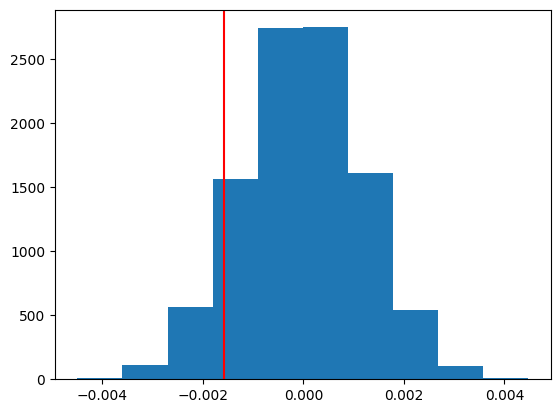

In [28]:
# convert to numpy array
p_diffs = np.array(p_diffs)

# plot distribution
null_vals =  np.random.normal(0, np.std(p_diffs), p_diffs.size)
plt.hist(null_vals)

# plot line for observed statistic
plt.axvline(x=obs_diff, c='r');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
# compute p value
(null_vals > obs_diff).mean()

0.9058

**k.** Let's explain in words what we have just computed in part **j** above.

**ANSWER:**
- The proportion of the p_diffs that are greater than the actual difference observed in the **df2** data is called the p-value. It is **the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**
- The null hypothesis states the treatment has no effect on the probability of conversion. We simulated the sampling distribution for the difference in conversion and computed the p-value by finding the proportion of values in the null distribution greater than our observed difference. Therefore, we do not have enough evidence to reject the null hypothesis.

**l.** Using built-in methods for Hypothesis Testing.


In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))

# number of conversions with the new_page
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page == "old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page == "new_page"'))

**m.** Use `sm.stats.proportions_ztest()` to compute our test statistic and p-value.

In [31]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j** and **k**?

**ANSWER:**

The conversion rate of the new landing page is only 1.3109 standard deviation away from the conversion rate of the old landing page, which is less than the critical value of 1.96 for two-tailed tests like this. The p-value is also similar to the one computed earlier. Therefore, we fail to reject the null hypothesis.

<a id='regression'></a>
## Part III - A regression approach

### Part 3.1
In this final part, let's see if the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br>

**a.** Since each row in the **df2** dataframe is either a conversion or no conversion, it is suggested that:

**ANSWER:** Logistic Regression is used to model the probability of a binary outcome.

**b.** We first need to create the following two columns in the **df2** dataframe:
 1. `intercept` - It should be `1` in the entire column.
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [32]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'] # treament = 1, control = 0
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


**c.** Use **statsmodels** to instantiate our regression model on the two columns we created in part (b) above, then fit the model to predict whether or not an individual converts.


In [33]:
log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of our model below, and use it as necessary to answer the following questions.

In [34]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-12-04 18:33 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.18988    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?


**ANSWER:**

The p-value associated with ab_page is 0.1899. It differs from the value found in Part II for several reasons:

- The null and alternative hypotheses associated with Part III's regression model (two-tailed test):

  $H_{0}$: $p_{new}$ - $p_{old}$ = 0
                    
  $H_{1}$: $p_{new}$ - $p_{old}$ ≠ 0
    

- The null and hypotheses in Part II (one-tailed test):

  $H_{0}$: $p_{new}$ - $p_{old}$ ≤ 0

  $H_{1}$: $p_{new}$ - $p_{old}$ > 0

Part III contains the Logistic Regression models, the output of which, by default, show the p-value for a two-tailed test. More specifically, all regression software tests:

- Whether the regression coefficient is zero (in this case whether the treatment variable influences conversion)
- Using a two-tailed test

**f.** Now, let's consider other things that might influence whether or not an individual converts.  Is it a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into your regression model?

In [35]:
# Calculate duration of the experiment
df2['timestamp'] = pd.to_datetime(df2['timestamp'], dayfirst=True)
df2['timestamp'].max() - df2['timestamp'].min()

Timedelta('21 days 23:59:49.081927')

**ANSWER:**

It would be useful to add interaction terms to the model if we wanted to test the hypothesis how the relationships between independent variables are related to the conversion rate:

- The duration of the experiment (in this case it was 21 days, which is rather short).

- If the pages were available in multiple languages, would they behave differently from country to country?

- Other metrics such as click through rate and average time spent on site can also provide meaningful insights.

On the other hand, adding many variables may create a tangle of causal relationships and makes it harder to trace which change is having which effect.

**g.** Adding countries .

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

1. We will need to read in the `countries.csv` dataset and merge together our **df2** datasets on the appropriate rows. Let's call the resulting dataframe **df_merged.**

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns.

In [37]:
# Read the countries.csv
countries = pd.read_csv('/content/drive/MyDrive/Data Science - Analyze A B test results/data/countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# Join with the df2 dataframe
df_merged = df2.join(countries.set_index('user_id'), on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [39]:
# Create the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged['country']))
df_merged.drop(['US'], axis=1, inplace=True) # Let's consider US as our baseline
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,CA_ab_page,UK_ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,1,0


**h.** Fit our model and obtain the results.

In [40]:
# Fit our model, and summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK', 'CA_ab_page', 'UK_ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [41]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-12-04 18:35 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.19199    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [42]:
1 / np.exp(results.params[1])

1.020776460348879

In [43]:
1 / np.exp(results.params[2])

1.017682333867224

In [44]:
1 / np.exp(results.params[3])

1.005760522870662

In [45]:
1 / np.exp(results.params[4])

1.048001022911517

In [46]:
1 / np.exp(results.params[5])

0.9690899932131409

**ANSWER:**

According to the coefficents:

- If a user was shown the new landing page, they are 1.02 times less likely to convert than if they were shown the old landing page, holding all other variables constant.

- If a user lived in Canada, they are 1.021 times less likely to convert than if they lived in the US, holding all other variables constant.

- If a user lived in the UK, they are 1.006 times less likely to convert than if they lived in the US, holding all other variables constant.

- The way that ab_page is related to converted is the same regardless of the country.

- The difference in conversion for the different countries is the same regardless of the ab_page.

In conclusion, we fail to reject the null hypothesis due to statistically insignificant p-value and the lack of interaction terms between the added variables.